# Estimacion de Fase cuántica (Quantum Phase Estimation)

In [1]:
!pip install -U qiskit-aer
!pip install -U pylatexenc
!pip install -U qiskit-ibm-runtime
!pip install -U --no-cache-dir qiskit

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import warnings
warnings.filterwarnings("ignore")
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=92d69e941d08e70623ae38bcfa2f05b37963b7d9e8a2b7d2ef8f7dfcb4587d2a
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

La estimación de fase cuántica es una de las subrutinas fundamentales en computación cuántica, desempeñando un papel central en numerosos algoritmos cuánticos. Su propósito principal es determinar con alta precisión la fase asociada a un autovalor de una operación cuántica dada:

> Dado un operador unitario $U$, el algoritmo estima el parámetro $\theta$ en la ecuación $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, donde $|\psi\rangle$ es un autovector y $e^{\boldsymbol{2\pi i}\theta}$ es el autovalor correspondiente. Debido a la unitariedad de $U$, todos sus autovalores tienen módulo igual a 1.
Realizaremos varios ejercicios para construir el circuito de este algoritmo y estimar las fases de distintos operadores. Primero, importamos las bibliotecas necesarias.


In [2]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
##from qiskit import IBMQ, Aer, transpile, assemble
##from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
##from qiskit.visualization import plot_histogram

Y una funcion para visualizar los resultados de las medidas:

In [3]:
def count_to_digital_values(counts):
    counts_ordenado=sorted(counts)
    print('resultado -- cuenta')
    for k in counts_ordenado:
        print(k, '     --',counts[k])

## Introducción

A continuación se muestra el circuito cuántico general para la estimación de fase.

El registro inferior es un registro auxiliar que llamaremos **registro contador o de conteo** y contiene $m$ qubits y el superior contiene $n$ qubits en el estado $|\psi\rangle$:

![image1](https://drive.google.com/uc?id=1QS32bbnnvnI5aBxPQ6e8ER3UIKL_h8Vv)



El algoritmo de estimación de fase cuántica emplea el **retroceso de fase** (*phase kick-back*) para codificar la fase de $U$ en la base de Fourier dentro de los $m$ qubits del registro de conteo. Posteriormente, se aplica la **Transformada Cuántica de Fourier inversa (QFT inversa)** para convertir esta información de la base de Fourier a la base computacional, permitiendo así su medición.



Cuando usamos un autovector para controlar la puerta $U$ sobre un qubit, el qubit girará (debido al **retroceso de fase**) proporcionalmente a la fase $e^{2i\pi\theta}$. Podemos usar sucesivas puertas $CU$ para repetir esta rotación un número apropiado de veces hasta que hayamos codificado la fase $\theta$ como un número entre $0$ y $2^m$ en la base de Fourier.
Finalmente, aplicamos la $IQFT$ para transformar este estado a la base computacional, permitiendo su medición.




### Funcionamiento del circuito QPE

Como se mencionó anteriormente, este circuito estima la fase de un operador unitario $U$. Estima $\theta$ en $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, donde $|\psi\rangle$ es un vector propio y $ e^{\boldsymbol{2\pi i}\theta}$ es el valor propio correspondiente. El circuito opera en los siguientes pasos:

0. **Setup**: $\vert\psi\rangle$ está en un conjunto de registros de qubit. Un conjunto adicional de $n$ qubits forma el registro de conteo en el que almacenaremos el valor $2^n\theta$:



$$ |\psi_0\rangle = \lvert 0 \rangle^{\otimes m}  \otimes \lvert \psi \rangle $$



1. **Superposición**: Apliqcamo una operación de puerta Hadamard de $m$ bits $H^{\otimes m}$, en el registro de conteo:



$$ |\psi_1\rangle = {\frac {1}{\sqrt {2^m}}}\left(|0\rangle +|1\rangle \right)^{\otimes m} \otimes \lvert \psi \rangle $$



2. **Operaciones Unitarias Controladas**: Necesitamos introducir el operador $CU$ unitario de la $U$ controlada que aplica el operador unitario $U$ en el registro de destino solo si su bit de control correspondiente es $|1\rangle$.

Dado que $U$ es un operador unitario con vector propio $|\psi\rangle$ tal que $U|\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, esto significa :

$$U^{2^{m}}|\psi \rangle =U^{2^{m-1}}U|\psi \rangle =U^{2^{m-1}}e^{2\pi i\theta }|\psi \rangle =\cdots =e^{2\pi i2^{m}\theta }|\psi \rangle$$


Aplicando todas las operaciones controladas $m$ $CU^{2^j}$ con $0\leq j\leq m-1$, y usando la relación $|0\rangle \otimes |\psi \rangle +|1\rangle \otimes e^{2\pi i\theta }|\psi \rangle =\left(|0\rangle +e^{2\pi i\theta }|1\rangle \right)\otimes |\psi \rangle$


\begin{aligned}
|\psi_{2}\rangle = \frac {1}{\sqrt{2^m}} \sum _{k=0}^{2^{m}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes \lvert \psi \rangle = QFT \vert2^m\theta\rangle \otimes \lvert \psi \rangle  
\end{aligned}



\begin{aligned}
|\psi_{2}\rangle & =  \frac {1}{\sqrt{2^m}} [ \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{m-1}}}|1\rangle \right) \otimes \cdots \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{1}}}\vert1\rangle \right) \otimes \left(|0\rangle+{e^{\boldsymbol{2\pi i} \theta 2^{0}}}\vert1\rangle \right)] \otimes \lvert \psi \rangle = \frac {1}{\sqrt{2^m}} \sum _{k=0}^{2^{m}-1}e^{\boldsymbol{2\pi i} \theta k}|k\rangle \otimes \lvert \psi \rangle
\end{aligned}
donde $k$ denota la representación entera de números binarios de m bits.

iv. **Transformada de Fourier inversa**: Observamos que la expresión anterior es exactamente el resultado de aplicar una transformada cuántica de Fourier. Recordamos que la QFT asigna un estado de entrada de m-qubit $\vert j\rangle$ a una salida como

$$\vert j \rangle \mapsto \frac{1}{\sqrt{2^m}}\sum_{k=0}^{2^m-1}e^{2\pi i \frac{jk}{2^m}} \vert k \rangle$$

$$
QFT\vert j_{m-1}j_{m-2}...j_0 \rangle = \frac{1}{\sqrt{2^m}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}j} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}j} \vert1\rangle\right)
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{m-1}}j} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^m}j} \vert1\rangle\right)
$$

Reemplazar $j$ por $2^m\theta$ en la expresión anterior da exactamente la expresión derivada en el paso 2 anterior. Por lo tanto, para recuperar el estado $\vert2^m\theta\rangle$, apliquamos una transformada de Fourier inversa en el registro de conteo auxiliar. Al hacerlo, encontramos $(2^m \theta)$ en el registro de conteo.

3. **Medición**:
Al medir los $m$ qubits del registro contador encontraremos un máximo de resultados cerca de $j = 2^m\theta$. Para el caso en que $2^m\theta$ es un número entero, medir en la base computacional da la fase exacta en el registro auxiliar con alta probabilidad:

$$ |\psi_4\rangle = | 2^m \theta \rangle $$

Para el caso en el que $2^m\theta$ no sea un número entero, se puede demostrar que la expresión anterior todavía alcanza su punto máximo cerca de $j = 2^m\theta$ con una probabilidad mejor que $4/\pi^2 \approx 40\%$.

## QPE para la puerta T

Tomemos una puerta que conocemos bien, la puerta $T$, y usemos la estimación de fase cuántica para estimar su fase. Recordemos que la puerta $T$ agrega una fase de $e^\frac{i\pi}{4}$ al estado $|1\rangle$:

$$ T|1\rangle =
\begin{bmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\
\end{bmatrix}
\begin{bmatrix}
0\\
1\\
\end{bmatrix}
= e^\frac{i\pi}{4}|1\rangle $$

Dado que QPE nos dará el angulo $\theta$ que cumple:

$$ T|1\rangle = e^{2i\pi\theta}|1\rangle $$

De forma que esperamos encontrar:

$$\theta = \frac{1}{8}$$

Utilizaremos $m=3$ qubits en el registro contador para obtener **un resultado exacto**. Esto es asi porque en este caso $2^m \theta=1$ es un numero entero y vamos a poder medir con total certidumbre la fase(no una estimacion!).

### EJERCICIO

Crea el circuito cuantico de la QPE para el operador T.

*   En nuestro caso tenemos $n=1$ qubit del registro del vector propio del operador T que es |1> y tomaremos $m=3$ qubits para la resolucion de la medida de fase en el registro de conteo

*   Crea un circuito cuantico de $n+m$ qubits y $m$ bits clasicos para recoger la medida de la fase

*   Inicializa el primer qubit $q_0$ a $\vert\psi\rangle = \vert1\rangle$ aplicando una puerta $X$

*   El resto de qubits ponlos en superposicion con la puesta de Hadamard $H$

*   Aplica las puertas $CU$, control $U$, que seguiran el siguiente patron: $U$ para el $qn$, $U^2$ para $q_{n+1}$ ... y $U^{2^{m-1}}$ para $q_{n+m-1}$. Recuerda que $U^k$ es equivalente a aplicar la puerta $U$ $k$ veces.

* Dibuja el circuito



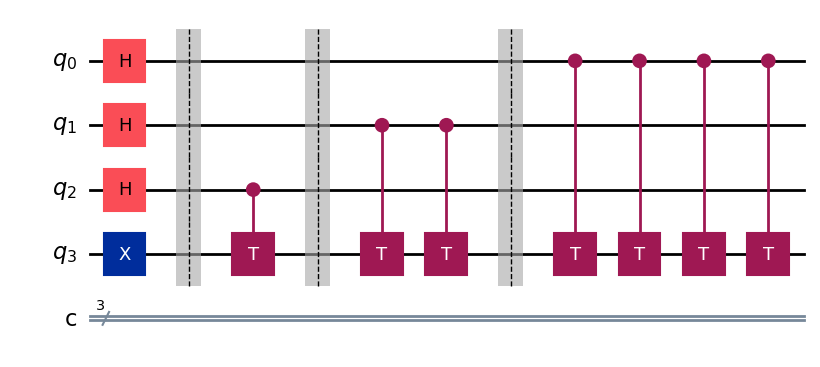

In [103]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TGate
import numpy as np

# Número de qubits
n = 1  # Qubits para el registro del vector propio
m = 3  # Qubits para el registro de conteo
target = m + n - 1  # Qubit al que se va a aplicar la puerta CU

# Crear el circuito cuántico
creg = ClassicalRegister(m, "c")  # Registros clásicos para la medida de la fase
qreg = QuantumRegister(n + m, "q")  # Registros cuánticos para el vector propio y el registro de conteo
circ = QuantumCircuit(qreg, creg)  # n+m qubits y m bits clásicos

# Inicializar el estado |1⟩ en el qubit q0
circ.x(m)

# Poner los qubits del registro de conteo en superposición
for i in range(0, m):
  circ.h(i)

# Aplicamos las puertas CU a los qubits q1...qm donde usaremos aplicaremos U un numero 2^(m-1) de veces
# Aplicar las puertas CU (T controlada)
for i in range(0, m):
  circ.barrier()
  pow = 2**i
  control = m - i - 1
  for j in range(pow): # aplicamos CU (U en este caso es T)
    circ.append(TGate().control(1), [control, target])

display(circ.draw(output='mpl'))

Ahora definimos la siguiente funcion que construye la QFT inversa para aplicarla a los $m$ ultimos qubits de un circuito de $n+m$ qubits:

In [104]:
from qiskit.circuit.library import QFT

def iqft(m, circ):
    iqft = QFT(m, do_swaps = False, inverse=True) # Seleccionamos el argumento de swap a false
    circ.append(iqft, range(m))

    return circ

Finalmente en nuestro de circuito de calculo de la QPE :

*   Ponemos una barrera
*   Añadimos el circuito de la QFT Inversa
*   Ponemos otra barrera y añadimos las puertas de medida
*   Dibujamos el circuito en una sola linea

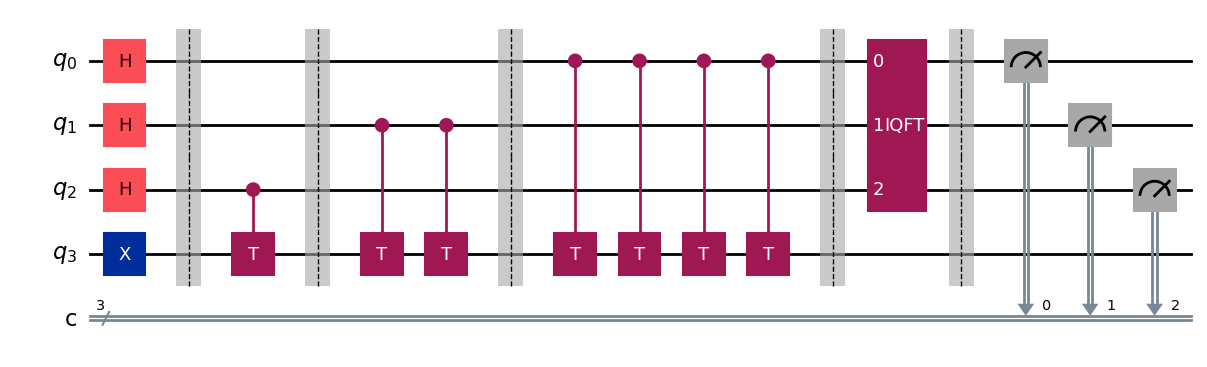

In [105]:
circ.barrier()

circ = iqft(m, circ)

circ.barrier()

# medimos los m primeros qubits
circ.measure(qreg[0:m], creg[0:m])

display(circ.draw(output='mpl'))

Ahora ejecutaremos el circuito y obtendremos la medida en el registro contador auxiliar

Obten el histograma de medidas en numerico y visualizandolo en una figura

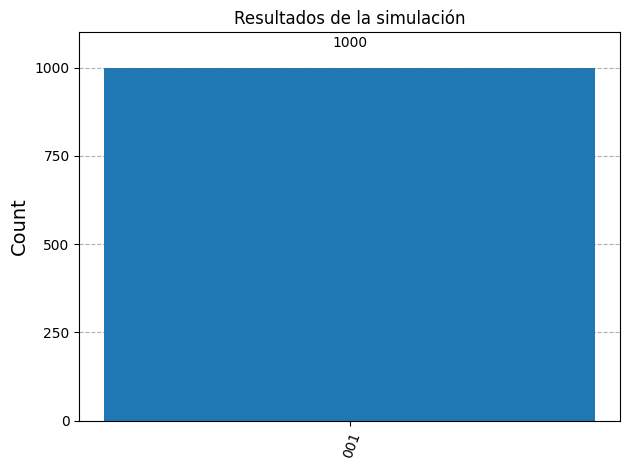

In [106]:
from qiskit import QuantumCircuit, QuantumRegister, transpile, ClassicalRegister
import numpy as np
from qiskit_aer import Aer

# Lanzamos el circuito en el simulador
backend = Aer.get_backend('qasm_simulator')
shots = 1000
compiled_circuit = transpile(circ, backend)
job = backend.run(compiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()


plot_histogram(counts, title='Resultados de la simulación')

Vemos que debemos de obtener es (`001`) con total certeza, lo que se traduce al decimal: `1`. Ahora necesitamos dividir nuestro resultado (`1`) por $2^m$ para obtener el resultado exacto de $\theta$:

$$ \theta = \frac{1}{2^3} = \frac{1}{8} $$

En este caso, hemos obtenido el resultado exacto porque $\theta$ es un numero entero.

### EJERCICIO

En lugar de una puerta $T$, usemos otra puerta de un qubit, la puerta $P(\frac{2\pi}{3})$  de rotacion con un angulo $\theta = \frac{1}{3}= 0.333$. El vector propio de este operador que es |1>.

Crea el circuito y mide los resultados de estimacion de fase tomando $m=3$ como numero de qubits en el registro de conteo

En este caso $2^m \theta=2.666$ no es un numero entero, por lo que no vamos a poder medir con total certidumbre la fase.

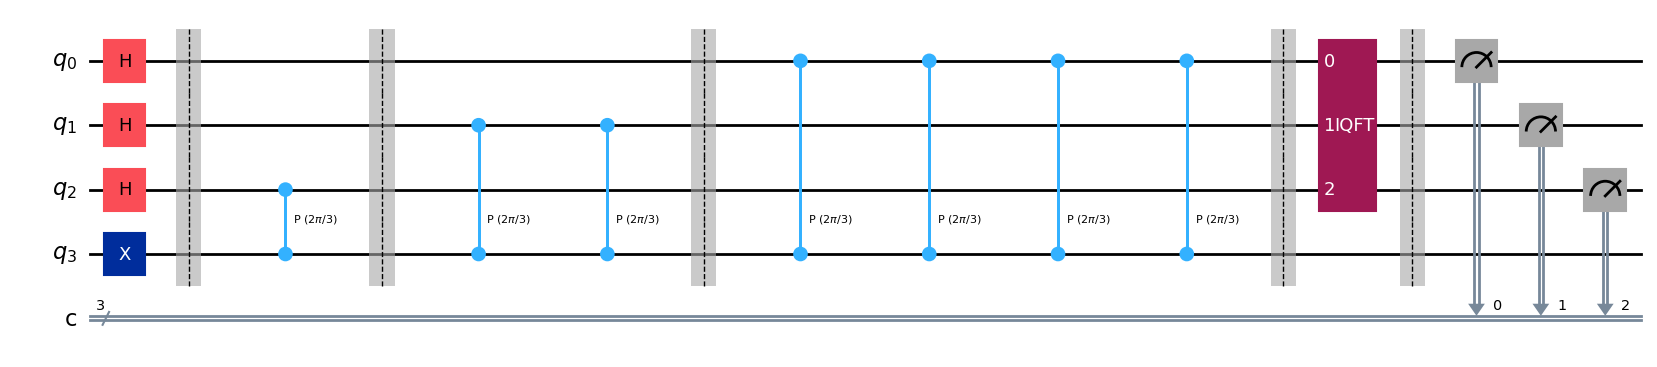

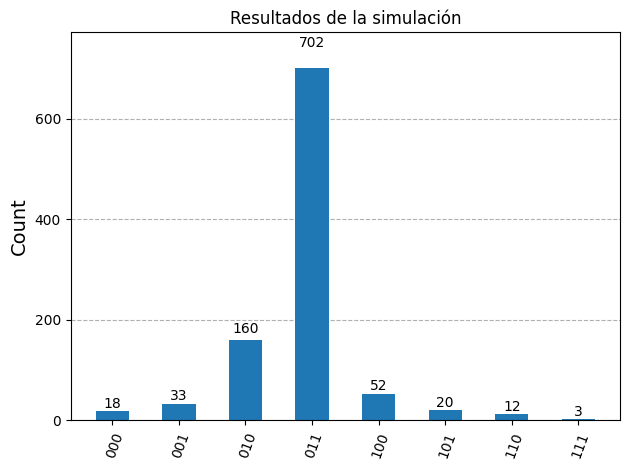

In [122]:
from qiskit.circuit.library import CPhaseGate

# Número de qubits
n = 1  # Qubits para el registro del vector propio
m = 3  # Qubits para el registro de conteo
target = m + n - 1  # Qubit al que se va a aplicar la puerta CU

# Crear el circuito cuántico
creg = ClassicalRegister(m, "c")  # Registros clásicos para la medida de la fase
qreg = QuantumRegister(n + m, "q")  # Registros cuánticos para el vector propio y el registro de conteo
circ2 = QuantumCircuit(qreg, creg)  # n+m qubits y m bits clásicos

# Inicializar el estado |1⟩ en el qubit q0
circ2.x(m)

# Poner los qubits del registro de conteo en superposición
for i in range(0, m):
  circ2.h(i)

# Aplicamos las puertas CU a los qubits q1...qm donde usaremos aplicaremos U un numero 2^(m-1) de veces
# Aplicar las puertas CU (T controlada)
for i in range(0, m):
  circ2.barrier()
  pow = 2**i
  control = m - i - 1
  for j in range(pow): # aplicamos CU (U en este caso es P(2*pi/3))
    circ2.append(CPhaseGate(2 * math.pi / 3), [control, target])

circ2.barrier()
circ2 = iqft(m, circ2)
circ2.barrier()
# medimos los m primeros qubits
circ2.measure(qreg[0:m], creg[0:m])

display(circ2.draw(output='mpl'))

# Lanzamos el circuito en el simulador
backend = Aer.get_backend('qasm_simulator')
shots = 1000
compiled_circuit = transpile(circ2, backend)
job = backend.run(compiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()


plot_histogram(counts, title='Resultados de la simulación')



Estamos esperando el resultado $\theta = 0.3333\dots$, pero con este circuito tenemos que obtener que nuestros resultados más probables son `010(bin) = 2(dec)` y `011(bin) = 3(dec)`. Estos dos resultados nos dirían que $\theta = 0,25$ (desviación del 25%) y $\theta = 0,375$ (desviación del 13%) respectivamente. El verdadero valor de $\theta$ se encuentra entre los valores que podemos obtener de nuestros bits de conteo, y esto nos da incertidumbre e imprecisión.

### EJERCICIO

Para obtener más precisión, simplemente agregamos más qubits de conteo. Vamos a agregar dos qubits de conteo más, tomando $m=5$

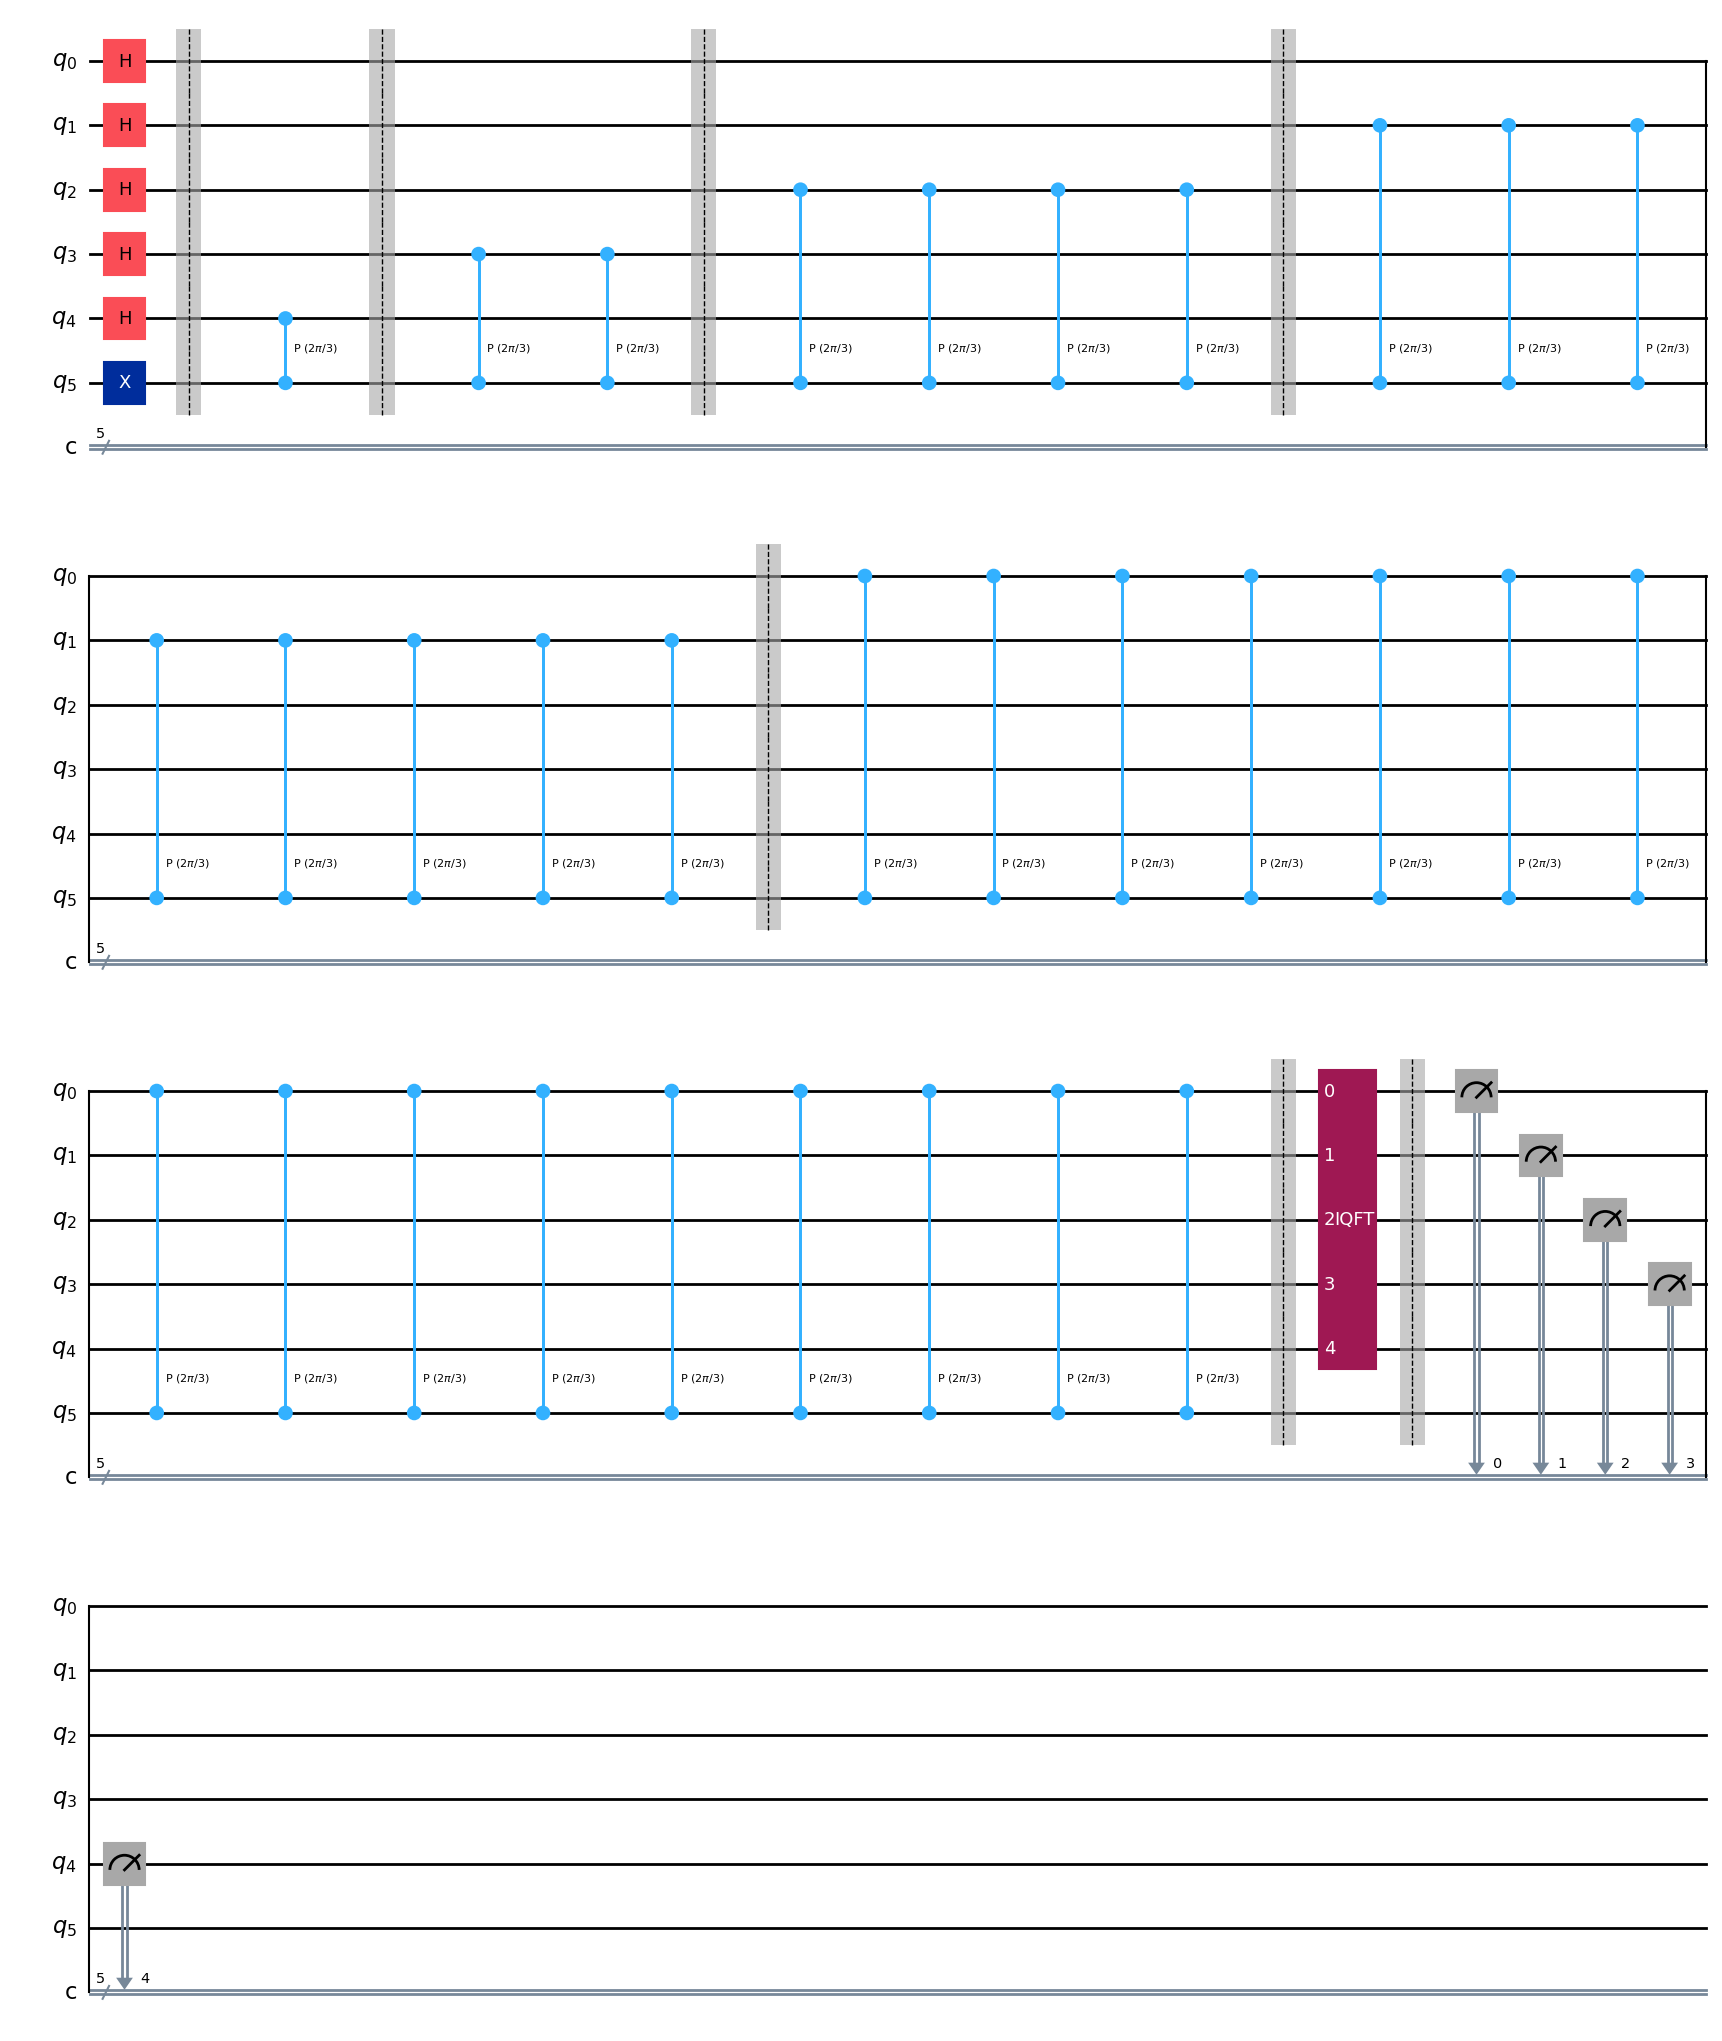

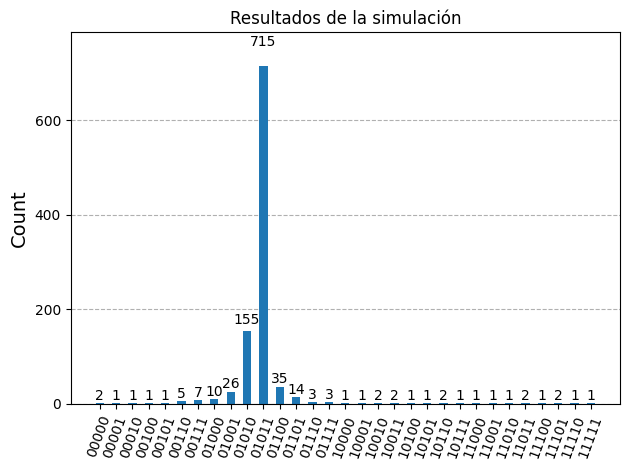

In [130]:
from qiskit.circuit.library import CPhaseGate

# Número de qubits
n = 1  # Qubits para el registro del vector propio
m = 5  # Qubits para el registro de conteo
target = m + n - 1  # Qubit al que se va a aplicar la puerta CU

# Crear el circuito cuántico
creg = ClassicalRegister(m, "c")  # Registros clásicos para la medida de la fase
qreg = QuantumRegister(n + m, "q")  # Registros cuánticos para el vector propio y el registro de conteo
circ3 = QuantumCircuit(qreg, creg)  # n+m qubits y m bits clásicos

# Inicializar el estado |1⟩ en el qubit q0
circ3.x(m)

# Poner los qubits del registro de conteo en superposición
for i in range(0, m):
  circ3.h(i)

# Aplicamos las puertas CU a los qubits q1...qm donde usaremos aplicaremos U un numero 2^(m-1) de veces
# Aplicar las puertas CU (T controlada)
for i in range(0, m):
  circ3.barrier()
  pow = 2**i
  control = m - i - 1
  for j in range(pow): # aplicamos CU (U en este caso es P(2*pi/3))
    circ3.append(CPhaseGate(2 * math.pi / 3), [control, target])

circ3.barrier()
circ3 = iqft(m, circ3)
circ3.barrier()
# medimos los m primeros qubits
circ3.measure(qreg[0:m], creg[0:m])

display(circ3.draw(output='mpl'))

# Lanzamos el circuito en el simulador
backend = Aer.get_backend('qasm_simulator')
shots = 1000
compiled_circuit = transpile(circ3, backend)
job = backend.run(compiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts()


plot_histogram(counts, title='Resultados de la simulación')



Las dos medidas más probables que debemos de obtener ahora son  "01011" (11 decimal) y "01010" (10 decimal). Medir estos resultados nos diría que $\theta$ es:

$$
\theta = \frac{11}{2^5} = 0.344,\;\text{ o }\;\; \theta = \frac{10}{2^5} = 0,313
$$

Estos dos resultados difieren de $\frac{1}{3}$ en un 3% y un 6% respectivamente. ¡Una precisión mucho mejor!

### EJERCICIO

Ejecuta el circuito los ejercicios anteriores, donde estimamos la fase de los operadores $T$ y $P(\frac{2\pi}{3})$  en un simulador con ruido

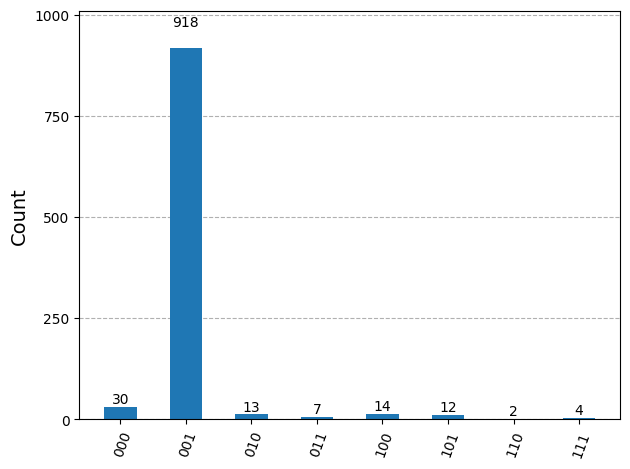

In [124]:
from qiskit.providers.fake_provider import GenericBackendV2

#qpe T \thta = 1
backend = GenericBackendV2(num_qubits = m + n)
transpiled = transpile(circ, backend = backend, optimization_level = 1)
job = backend.run(transpiled, shots = 1000)
result = job.result()
counts = result.get_counts()

display(plot_histogram(counts))

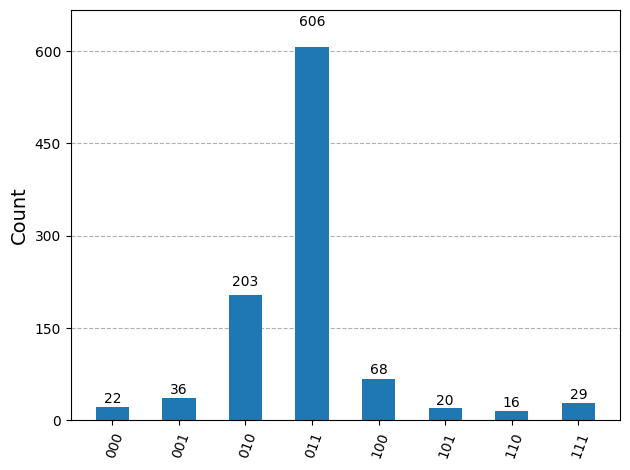

In [125]:
#qpe P \theta 1/3
from qiskit.providers.fake_provider import GenericBackendV2

#qpe T \thta = 1
backend = GenericBackendV2(num_qubits = m + n)
transpiled = transpile(circ2, backend = backend, optimization_level = 1)
job = backend.run(transpiled, shots = 1000)
result = job.result()
counts = result.get_counts()

display(plot_histogram(counts))

## Ejecucion en un BackEnd cuántico

### EJERCICIO

Ejecuta los circuitos anteriores en Backend cuántico real

Se ha vuelto a crear el circuito, esta vez sin barreras ya que como se vio en una practica anterior las barreras hacen que los resultados se desvien.

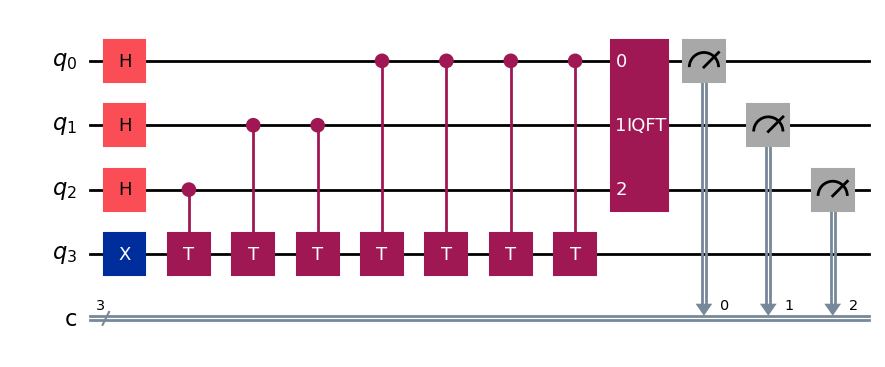

<IBMBackend('ibm_sherbrooke')>
job id: czzrepad8drg008j4fh0
{'101': 726, '001': 7777, '000': 535, '111': 305, '011': 362, '010': 125, '100': 123, '110': 47}


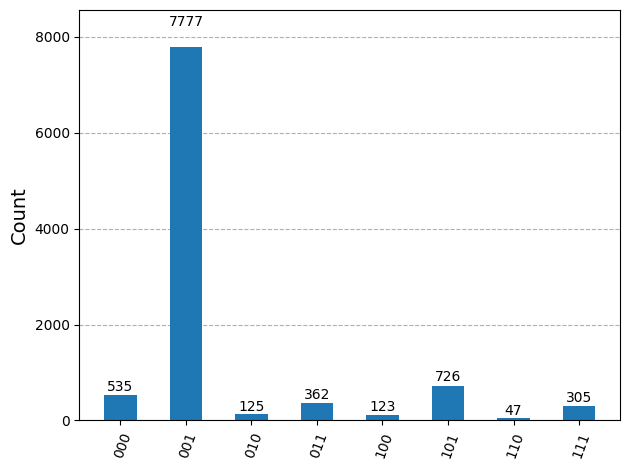

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Número de qubits
n = 1  # Qubits para el registro del vector propio
m = 3  # Qubits para el registro de conteo
target = m + n - 1  # Qubit al que se va a aplicar la puerta CU

# Crear el circuito cuántico
creg = ClassicalRegister(m, "c")  # Registros clásicos para la medida de la fase
qreg = QuantumRegister(n + m, "q")  # Registros cuánticos para el vector propio y el registro de conteo
t_real = QuantumCircuit(qreg, creg)  # n+m qubits y m bits clásicos

# Inicializar el estado |1⟩ en el qubit q0
t_real.x(m)

# Poner los qubits del registro de conteo en superposición
for i in range(0, m):
  t_real.h(i)

# Aplicamos las puertas CU a los qubits q1...qm donde usaremos aplicaremos U un numero 2^(m-1) de veces
# Aplicar las puertas CU (T controlada)
for i in range(0, m):
  pow = 2**i
  control = m - i - 1
  for j in range(pow): # aplicamos CU (U en este caso es T)
    t_real.append(TGate().control(1), [control, target])

t_real = iqft(m, t_real)
# medimos los m primeros qubits
t_real.measure(qreg[0:m], creg[0:m])

display(t_real.draw(output='mpl'))

# Auth token for IBM Quantum
token = ""

service = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend = service.backend("ibm_sherbrooke")
print(backend)

pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(t_real)

#Mostramos el circuito compilado al computador cuántico real
isa_circuit.draw("mpl", idle_wires=False)

sampler = Sampler(backend)
job = sampler.run([isa_circuit], shots=10000)
print(f"job id: {job.job_id()}")
result = job.result()

#Mostramos los resultados
for item in result._pub_results[0].data.items():
    print(item[1].get_counts())
    display(plot_histogram(item[1].get_counts()))

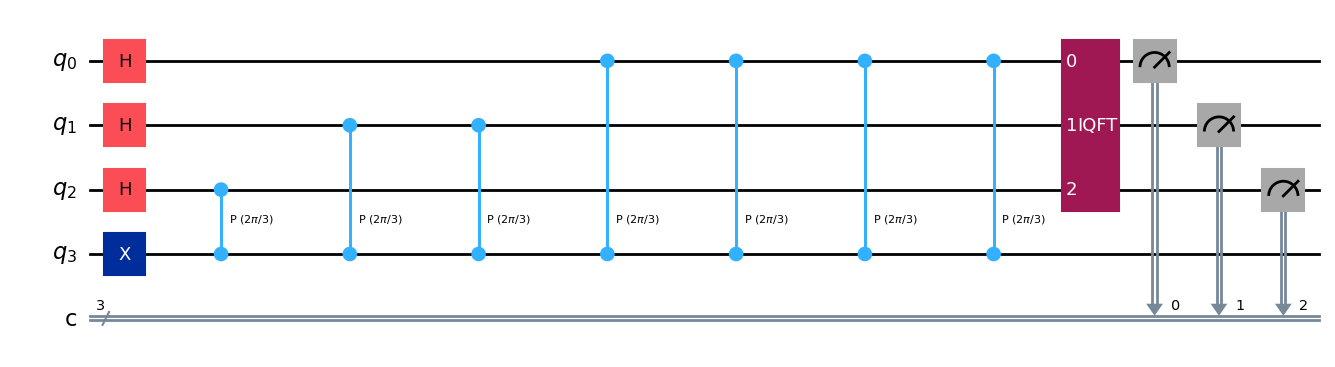

<IBMBackend('ibm_sherbrooke')>
job id: czzrr89nhqag008v0cvg
{'100': 8454, '111': 7306, '010': 7117, '011': 66119, '000': 2283, '110': 3983, '101': 2586, '001': 2152}


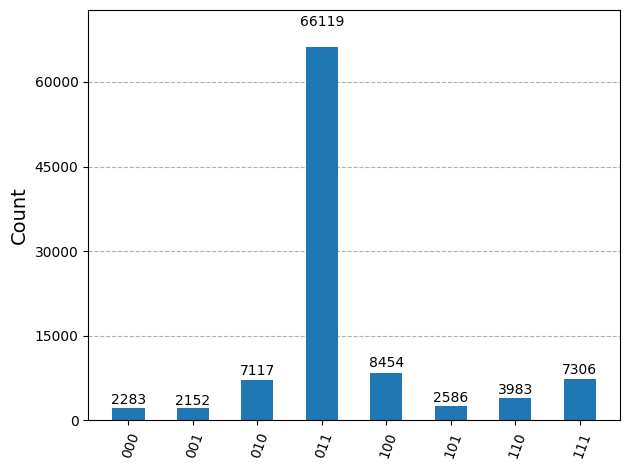

In [ ]:
from qiskit.circuit.library import CPhaseGate

# Número de qubits
n = 1  # Qubits para el registro del vector propio
m = 3  # Qubits para el registro de conteo
target = m + n - 1  # Qubit al que se va a aplicar la puerta CU

# Crear el circuito cuántico
creg = ClassicalRegister(m, "c")  # Registros clásicos para la medida de la fase
qreg = QuantumRegister(n + m, "q")  # Registros cuánticos para el vector propio y el registro de conteo
p_circ = QuantumCircuit(qreg, creg)  # n+m qubits y m bits clásicos

# Inicializar el estado |1⟩ en el qubit q0
p_circ.x(m)

# Poner los qubits del registro de conteo en superposición
for i in range(0, m):
  p_circ.h(i)

# Aplicamos las puertas CU a los qubits q1...qm donde usaremos aplicaremos U un numero 2^(m-1) de veces
# Aplicar las puertas CU (T controlada)
for i in range(0, m):
  pow = 2**i
  control = m - i - 1
  for j in range(pow): # aplicamos CU (U en este caso es P(2*pi/3))
    p_circ.append(CPhaseGate(2 * math.pi / 3), [control, target])

p_circ = iqft(m, p_circ)
# medimos los m primeros qubits
p_circ.measure(qreg[0:m], creg[0:m])

display(p_circ.draw(output='mpl'))

# Auth token for IBM Quantum
token = ""

service = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend = service.backend("ibm_sherbrooke")
print(backend)

pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(p_circ)

#Mostramos el circuito compilado al computador cuántico real
isa_circuit.draw("mpl", idle_wires=False)

sampler = Sampler(backend)
job = sampler.run([isa_circuit], shots=100000)
print(f"job id: {job.job_id()}")
result = job.result()

#Mostramos los resultados
for item in result._pub_results[0].data.items():
    print(item[1].get_counts())
    display(plot_histogram(item[1].get_counts()))
